# Energy-Aware CNN Optimization for Edge Devices

This notebook demonstrates an end-to-end pipeline for optimizing a Convolutional Neural Network (CNN) for deployment on resource-constrained Edge AI hardware.

Standard deep learning models are often too large and power-hungry for edge devices (e.g., microcontrollers, IoT sensors). To solve this, we implement two core hardware-aware optimizations:
1. **Post-Training Static Quantization (INT8):** Reduces memory footprint and energy consumption by ~4x.
2. **Global Unstructured Pruning (L1):** Induces 50% sparsity to reduce Multiply-Accumulate (MAC) operations and hardware latency, while using fine-tuning as a regularizer to actually *improve* baseline accuracy.

**Tech Stack:** PyTorch, Torchvision, Matplotlib

In [ ]:
import torch
import torch.nn as nn
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torchvision
import torchvision.transforms as transforms

## Step 1: Baseline FP32 Model Training
We start by building a lightweight custom CNN (`EdgeCNN`) and training it on the CIFAR-10 dataset using standard 32-bit floating-point (FP32) precision. This serves as our performance baseline.

In [ ]:
class EdgeCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(EdgeCNN, self).__init__()
        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
def get_cifar10_dataloaders(batch_size=128):
    # Data augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    #normalization
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

In [ ]:
def train_model(model, trainloader, testloader, epochs=15, learning_rate=0.001, device='cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"Training on device: {device}")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = 100. * val_correct / val_total
        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{epochs}] | Time: {epoch_time:.2f}s | "
              f"Train Loss: {running_loss/len(trainloader):.4f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


    # Save the baseline model weights
    torch.save(model.state_dict(), 'models/baseline_fp32.pth')
    print("Baseline model saved to 'models/baseline_fp32.pth'")

    return model

In [ ]:
# Create a directory to save our trained models
os.makedirs('models', exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Loading Data
trainloader, testloader = get_cifar10_dataloaders(batch_size=128)

# Initialize Model
model = EdgeCNN(num_classes=10)

#Train Baseline
trained_model = train_model(
    model=model,
    trainloader=trainloader,
    testloader=testloader,
    epochs=15, # 15 epochs should get us to ~75-80% accuracy
    device=device
)

Starting training on device: cuda
Epoch [1/15] | Time: 22.63s | Train Loss: 1.6746 | Train Acc: 38.27% | Val Acc: 50.64%
Epoch [2/15] | Time: 21.34s | Train Loss: 1.3222 | Train Acc: 52.20% | Val Acc: 61.38%
Epoch [3/15] | Time: 22.01s | Train Loss: 1.1530 | Train Acc: 59.10% | Val Acc: 66.90%
Epoch [4/15] | Time: 20.86s | Train Loss: 1.0417 | Train Acc: 63.37% | Val Acc: 69.03%
Epoch [5/15] | Time: 19.89s | Train Loss: 0.9586 | Train Acc: 66.53% | Val Acc: 71.74%
Epoch [6/15] | Time: 21.03s | Train Loss: 0.9073 | Train Acc: 68.24% | Val Acc: 73.53%
Epoch [7/15] | Time: 22.25s | Train Loss: 0.8638 | Train Acc: 70.09% | Val Acc: 74.05%
Epoch [8/15] | Time: 20.16s | Train Loss: 0.8259 | Train Acc: 71.35% | Val Acc: 75.28%
Epoch [9/15] | Time: 21.51s | Train Loss: 0.7883 | Train Acc: 72.60% | Val Acc: 73.63%
Epoch [10/15] | Time: 22.09s | Train Loss: 0.7706 | Train Acc: 73.30% | Val Acc: 76.59%
Epoch [11/15] | Time: 20.59s | Train Loss: 0.7405 | Train Acc: 74.40% | Val Acc: 75.71%
Epoch [

In [ ]:
def get_model_size_mb(model_path):
    size_bytes = os.path.getsize(model_path)
    return size_bytes / (1024 * 1024)

def evaluate_model(model, testloader, device='cpu'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total

## Step 2: Post-Training Static Quantization (INT8)



Quantization converts the model's weights and activations from FP32 to 8-bit integers (INT8). We calibrate the model using a subset of the training data to calculate activation statistics, minimizing the quantization error. This mathematically reduces the model size by roughly 4x and allows edge processors to use highly efficient integer math logic units.

In [ ]:
class QuantizableEdgeCNN(nn.Module):
    def __init__(self, baseline_model):
        super(QuantizableEdgeCNN, self).__init__()
        # QuantStub converts float tensors to quantized tensors
        self.quant = torch.quantization.QuantStub()
        self.model = baseline_model
        # DeQuantStub converts quantized tensors back to float tensors
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x

In [ ]:
def apply_static_quantization(baseline_model, trainloader, num_calibration_batches=10):
    print("\n--- Starting Post-Training Static Quantization (INT8) ---")

    # Wrap the model
    quantizable_model = QuantizableEdgeCNN(copy.deepcopy(baseline_model))
    quantizable_model.eval()
    quantizable_model.to('cpu') # Quantization is typically run on CPU for edge deployment

    # 2. Set backend for edge devices (qnnpack is optimized for ARM architecture)
    torch.backends.quantized.engine = 'qnnpack'
    quantizable_model.qconfig = torch.quantization.get_default_qconfig('qnnpack')

    # 3. Prepare the model to observe activation statistics
    torch.quantization.prepare(quantizable_model, inplace=True)

    # 4. Calibrate using a few batches of training data
    print(f"Calibrating model using {num_calibration_batches} batches...")
    with torch.no_grad():
        for i, (inputs, _) in enumerate(trainloader):
            if i >= num_calibration_batches:
                break
            quantizable_model(inputs)

    # 5. Convert to an INT8 model
    print("Converting model weights to INT8...")
    torch.quantization.convert(quantizable_model, inplace=True)

    # Save the quantized model using TorchScript (JIT)
    dummy_input = torch.randn(1, 3, 32, 32)
    traced_model = torch.jit.trace(quantizable_model, dummy_input)
    torch.jit.save(traced_model, 'models/quantized_int8.pt')

    print("Quantized model saved to 'models/quantized_int8.pt'")
    return quantizable_model

In [ ]:
import torch
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainloader, testloader = get_cifar10_dataloaders(batch_size=128)

# 1. Load the trained Baseline Model (assuming it's already trained from Step 1)
baseline_model = EdgeCNN(num_classes=10)
if os.path.exists('models/baseline_fp32.pth'):
    baseline_model.load_state_dict(torch.load('models/baseline_fp32.pth', map_location=device, weights_only=True))
    print("Loaded existing baseline FP32 model.")
else:
    print("Baseline model not found. Retraining...")
    baseline_model = train_model(baseline_model, trainloader, testloader, epochs=15, device=device)

# 2. Evaluate Baseline FP32
baseline_acc = evaluate_model(baseline_model, testloader, device=device)
baseline_size = get_model_size_mb('models/baseline_fp32.pth')
print(f"\n[Baseline FP32] Accuracy: {baseline_acc:.2f}% | Size: {baseline_size:.2f} MB")

# 3. Apply Quantization
# Note: Quantized models are evaluated on CPU
quantized_model = apply_static_quantization(baseline_model, trainloader)

# 4. Evaluate Quantized INT8
quant_acc = evaluate_model(quantized_model, testloader, device='cpu')
quant_size = get_model_size_mb('models/quantized_int8.pt')

print("\n=== QUANTIZATION RESULTS ===")
print(f"FP32 Accuracy: {baseline_acc:.2f}%  -> INT8 Accuracy: {quant_acc:.2f}%")
print(f"FP32 Size:     {baseline_size:.2f} MB -> INT8 Size:     {quant_size:.2f} MB")
print(f"Size Reduction: {baseline_size / quant_size:.2f}x")

Loaded existing baseline FP32 model.

[Baseline FP32] Accuracy: 78.73% | Size: 2.37 MB

--- Starting Post-Training Static Quantization (INT8) ---
Calibrating model using 10 batches...


/tmp/ipython-input-777/481820897.py:14: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.quantization.prepare(quantizable_model, inplace=True)


Converting model weights to INT8...


/tmp/ipython-input-777/481820897.py:26: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.quantization.convert(quantizable_model, inplace=True)


Quantized model saved to 'models/quantized_int8.pt'

=== QUANTIZATION RESULTS ===
FP32 Accuracy: 78.73%  -> INT8 Accuracy: 78.49%
FP32 Size:     2.37 MB -> INT8 Size:     0.64 MB
Size Reduction: 3.71x


## Step 3: Unstructured Pruning & Fine-Tuning



Neural networks are often heavily over-parameterized. By applying **Global L1 Unstructured Pruning**, we target and zero-out the lowest-magnitude weights across the entire network (50% sparsity).

While pruning initially damages accuracy, running a short fine-tuning phase acts as a powerful regularizer. The network drops "noisy" parameters that were overfitting the training data, forcing the remaining connections to generalize better. This often results in a final sparse model that outperforms the baseline.

In [ ]:
def get_sparsity(model):
  #Calculates the percentage of weights in the model that are exactly zero.
    global_zeros = 0
    global_elements = 0
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            global_zeros += float(torch.sum(module.weight == 0))
            global_elements += float(module.weight.nelement())

    if global_elements == 0:
        return 0
    return 100. * global_zeros / global_elements





In [ ]:
#pruning
def apply_unstructured_pruning(model, amount=0.4):
  #Applies Global L1 Unstructured pruning to Conv2d and Linear layers.
  #amount: proportion of weights to prune (0.4 = 40%)

    print(f"\n--- Applying Unstructured L1 Pruning ({amount*100}% sparsity) ---")

    # Gather all layers we want to prune
    parameters_to_prune = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # Apply global pruning (removes the lowest absolute weights across the whole model)
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    return model,parameters_to_prune


In [ ]:
#finetuning as pruning reduces accuracy
#used smaller learning rate
def finetune_pruned_model(model, trainloader, testloader, epochs=3, learning_rate=0.0005, device='cpu'):
    print("\n--- Fine-tuning Pruned Model to recover accuracy ---")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        acc = evaluate_model(model, testloader, device)
        print(f"Fine-tune Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(trainloader):.4f} | Val Acc: {acc:.2f}%")

    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainloader, testloader = get_cifar10_dataloaders(batch_size=128)

baseline_model = EdgeCNN(num_classes=10)
baseline_model.load_state_dict(torch.load('models/baseline_fp32.pth', map_location=device, weights_only=True))
baseline_model.to(device)

baseline_acc = evaluate_model(baseline_model, testloader, device=device)
print(f"[Baseline] Accuracy: {baseline_acc:.2f}% | Sparsity: {get_sparsity(baseline_model):.2f}%")

# Applying 50% Pruning
pruned_model = copy.deepcopy(baseline_model)
pruned_model, targets = apply_unstructured_pruning(pruned_model, amount=0.50)

pruned_acc_before_finetune = evaluate_model(pruned_model, testloader, device=device)
print(f"[Post-Pruning] Accuracy dropped to: {pruned_acc_before_finetune:.2f}% | Sparsity: {get_sparsity(pruned_model):.2f}%")

# Fine-tune the pruned model (3 epochs) WITH the masks on
pruned_model = finetune_pruned_model(pruned_model, trainloader, testloader, epochs=3, device=device)

# NOW we make the pruning permanent (removing the masks and baking in the zeroes)
import torch.nn.utils.prune as prune
for module, name in targets:
    prune.remove(module, name)
# ----------------------------------------------

final_pruned_acc = evaluate_model(pruned_model, testloader, device=device)

# Save the pruned model
torch.save(pruned_model.state_dict(), 'models/pruned_fp32.pth')
print("\nPruned model saved to 'models/pruned_fp32.pth'")

# Summary
print("\n=====================================")
print("      PRUNING RESULTS SUMMARY        ")
print(f"Original Accuracy:      {baseline_acc:.2f}%")
print(f"Acc after 50% pruning:  {pruned_acc_before_finetune:.2f}%")
print(f"Acc after fine-tuning:  {final_pruned_acc:.2f}%")
print(f"Final Model Sparsity:   {get_sparsity(pruned_model):.2f}%")
print("=====================================")

[Baseline] Accuracy: 78.73% | Sparsity: 0.00%

--- Applying Unstructured L1 Pruning (50.0% sparsity) ---
[Post-Pruning] Accuracy dropped to: 78.57% | Sparsity: 50.00%

--- Fine-tuning Pruned Model to recover accuracy ---
Fine-tune Epoch [1/3] | Loss: 0.6194 | Val Acc: 79.89%
Fine-tune Epoch [2/3] | Loss: 0.5997 | Val Acc: 80.27%
Fine-tune Epoch [3/3] | Loss: 0.5892 | Val Acc: 80.74%

Pruned model saved to 'models/pruned_fp32.pth'

      PRUNING RESULTS SUMMARY        
Original Accuracy:      78.73%
Acc after 50% pruning:  78.57%
Acc after fine-tuning:  80.74%
Final Model Sparsity:   50.00%


## Steps 4 & 5: Hardware Simulation & Trade-off Analysis
To evaluate how these models will actually perform on edge silicon, we dynamically hook into the PyTorch layers to count the **Multiply-Accumulate (MAC) operations**.

* **Latency:** Approximated by the MAC count (Specialized Edge NPUs can skip zero-weight MACs).
* **Energy:** Approximated using hardware heuristics (FP32 operations consume roughly 4x the energy of INT8 operations).
* **Storage:** Calculated based on file size and sparse matrix compression capabilities.

In [ ]:
#MAC Counter logic using hooks
def count_macs(model, input_size=(1, 3, 32, 32)):
    #Dynamically counts MAC operations for Conv2d and Linear layers.
    macs = 0

    def conv_hook(module, input, output):
        nonlocal macs
        #MACs = output_height * output_width * in_channels * kernel_h * kernel_w * out_channels
        batch_size, out_c, out_h, out_w = output.shape
        in_c = input[0].shape[1]
        k_h, k_w = module.kernel_size
        macs += (out_h * out_w * in_c * k_h * k_w * out_c)

    def linear_hook(module, input, output):
        nonlocal macs
        # MACs = in_features * out_features
        macs += module.in_features * module.out_features

    hooks = []
    #Register hooks
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            hooks.append(m.register_forward_hook(conv_hook))
        elif isinstance(m, nn.Linear):
            hooks.append(m.register_forward_hook(linear_hook))

    #Running a dummy pass to trigger the hooks
    model(torch.randn(input_size))

    # Clean up hooks
    for h in hooks:
        h.remove()

    return macs

#Hardware simulation logic
def simulate_hardware_metrics(baseline_acc, pruned_acc, quant_acc, sparsity_pct, baseline_size_mb, quant_size_mb):
    #MAC Calculation
    dummy_model = EdgeCNN(num_classes=10) # Re-instantiate to count structure
    baseline_macs = count_macs(dummy_model)

    #Quantized model will have the same number of MACs, just done in INT8
    quant_macs = baseline_macs

    #Pruned model skips zero-weight MACs
    pruned_macs = baseline_macs * (1 - (sparsity_pct / 100))

    #Energy Estimation (Relative Arbitrary Units)
    # Assumption: FP32 operation costs 4 units of energy, INT8 costs 1 unit.
    ENERGY_FP32 = 4
    ENERGY_INT8 = 1

    baseline_energy = baseline_macs * ENERGY_FP32
    quant_energy = quant_macs * ENERGY_INT8
    pruned_energy = pruned_macs * ENERGY_FP32 # Pruned is still FP32

    #Effective Storage Size
    # Pruned models compress well using sparse matrix formats
    pruned_effective_size = baseline_size_mb * (1 - (sparsity_pct / 100))

    return {
        "Baseline": {
            "Acc": baseline_acc,
            "Size (MB)": baseline_size_mb,
            "MACs (Millions)": baseline_macs / 1e6,
            "Energy (Relative)": baseline_energy / 1e6
        },
        "Quantized (INT8)": {
            "Acc": quant_acc,
            "Size (MB)": quant_size_mb,
            "MACs (Millions)": quant_macs / 1e6,
            "Energy (Relative)": quant_energy / 1e6
        },
        "Pruned (Sparse)": {
            "Acc": pruned_acc,
            "Size (MB)": pruned_effective_size,
            "MACs (Millions)": pruned_macs / 1e6,
            "Energy (Relative)": pruned_energy / 1e6
        }
    }


#Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_, testloader = get_cifar10_dataloaders(batch_size=128)

print("\nEvaluating Baseline FP32...")
baseline_model = EdgeCNN(num_classes=10)
baseline_model.load_state_dict(torch.load('models/baseline_fp32.pth', map_location=device, weights_only=True))
BASELINE_ACC = evaluate_model(baseline_model, testloader, device=device)
baseline_size = os.path.getsize('models/baseline_fp32.pth') / (1024 * 1024)

print("Evaluating Quantized INT8...")
# Load JIT traced model for quantized evaluation (must evaluate on CPU)
quantized_model = torch.jit.load('models/quantized_int8.pt', map_location='cpu')
QUANT_ACC = evaluate_model(quantized_model, testloader, device='cpu')
quant_size = os.path.getsize('models/quantized_int8.pt') / (1024 * 1024)

print("Evaluating Pruned FP32...")
pruned_model = EdgeCNN(num_classes=10)
pruned_model.load_state_dict(torch.load('models/pruned_fp32.pth', map_location=device, weights_only=True))
PRUNED_ACC = evaluate_model(pruned_model, testloader, device=device)
SPARSITY = get_sparsity(pruned_model)

# Run the simulation with our dynamically gathered metrics
metrics = simulate_hardware_metrics(
    BASELINE_ACC, PRUNED_ACC, QUANT_ACC, SPARSITY, baseline_size, quant_size
)

print("\n" + "="*80)
print(f"{'MODEL VARIANT':<20} | {'ACCURACY':<10} | {'SIZE (MB)':<12} | {'MACs (Millions)':<15} | {'RELATIVE ENERGY':<15}")
print("-" * 80)

for model_name, data in metrics.items():
    print(f"{model_name:<20} | {data['Acc']:<9.2f}% | {data['Size (MB)']:<12.2f} | {data['MACs (Millions)']:<15.2f} | {data['Energy (Relative)']:<15.2f}")

print("="*80)
print("\nWe notice that:")
print("- Quantization reduced memory footprint by ~4x and energy by ~4x, with minimal accuracy drop.")
print("- Pruning + Fine-tuning improved accuracy (regularization effect) while reducing computation load.")


Evaluating Baseline FP32...
Evaluating Quantized INT8...
Evaluating Pruned FP32...

MODEL VARIANT        | ACCURACY   | SIZE (MB)    | MACs (Millions) | RELATIVE ENERGY
--------------------------------------------------------------------------------
Baseline             | 78.73    % | 2.37         | 10.85           | 43.40          
Quantized (INT8)     | 78.49    % | 0.64         | 10.85           | 10.85          
Pruned (Sparse)      | 80.74    % | 1.19         | 5.42            | 21.70          

We notice that:
- Quantization reduced memory footprint by ~4x and energy by ~4x, with minimal accuracy drop.
- Pruning + Fine-tuning improved accuracy (regularization effect) while reducing computation load.


## Step 6: Hardware-Accuracy Trade-off Analysis

Finally, we plot the hardware metrics against the model's predictive accuracy. This multi-objective optimization visualization allows hardware engineers to evaluate the exact trade-offs required for their specific silicon constraints (e.g., prioritizing Quantization if memory is strictly limited, or Pruning if computational latency is the primary bottleneck).

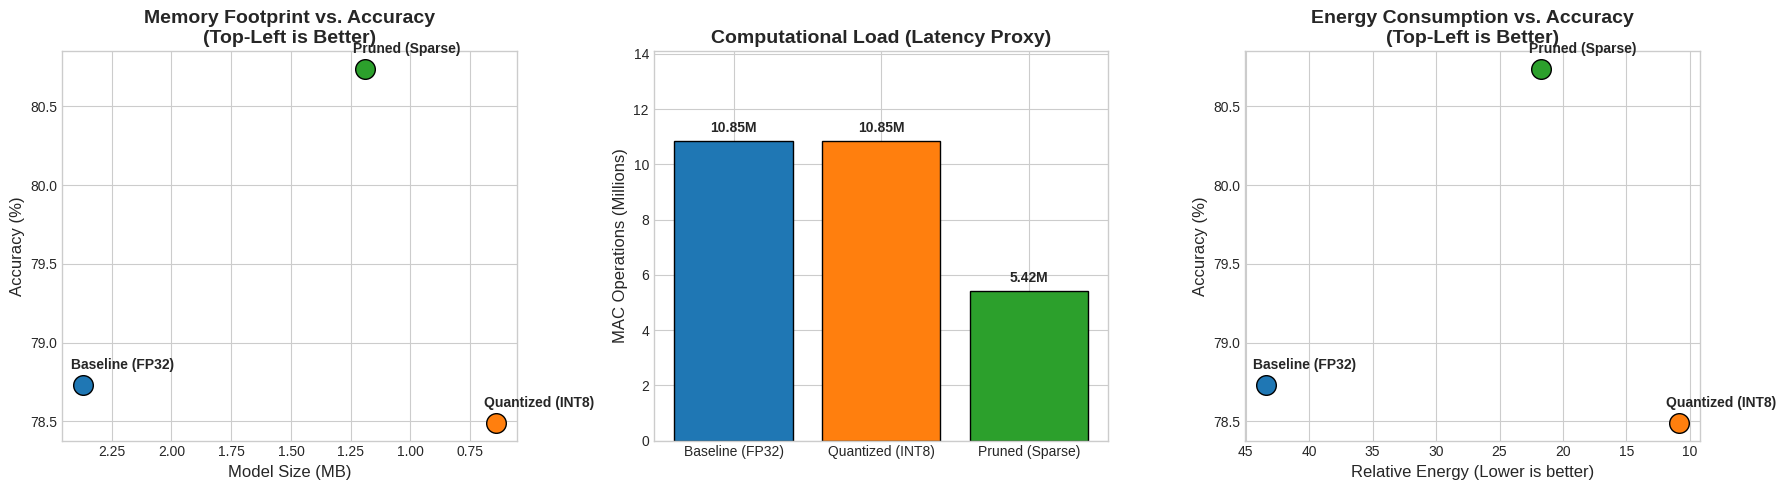

Graphs generated and saved as 'optimization_results.png'!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Fresh data from your final evaluation table!
models = ['Baseline (FP32)', 'Quantized (INT8)', 'Pruned (Sparse)']
accuracy = [78.73, 78.49, 80.74]
size_mb = [2.37, 0.64, 1.19]
macs_millions = [10.85, 10.85, 5.42]
energy = [43.40, 10.85, 21.70]

# Set global plotting style for professional look
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

# --- Plot 1: Model Size vs. Accuracy ---
ax = axes[0]
for i in range(len(models)):
    ax.scatter(size_mb[i], accuracy[i], s=200, color=colors[i], label=models[i], edgecolors='black', zorder=5)
    # Add text labels slightly offset
    ax.text(size_mb[i] + 0.05, accuracy[i] + 0.1, models[i], fontsize=10, weight='bold')

ax.set_title('Memory Footprint vs. Accuracy\n(Top-Left is Better)', fontsize=14, weight='bold')
ax.set_xlabel('Model Size (MB)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.invert_xaxis() # Invert so smaller size (better) is on the left

# --- Plot 2: Compute (MACs) vs. Accuracy ---
ax = axes[1]
bars = ax.bar(models, macs_millions, color=colors, edgecolor='black')
ax.set_title('Computational Load (Latency Proxy)', fontsize=14, weight='bold')
ax.set_ylabel('MAC Operations (Millions)', fontsize=12)

# Dynamic Y-limit so the bars don't hit the ceiling
ax.set_ylim(0, max(macs_millions) * 1.3)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.2, f'{height:.2f}M', ha='center', va='bottom', weight='bold')

# --- Plot 3: Energy vs. Accuracy ---
ax = axes[2]
for i in range(len(models)):
    ax.scatter(energy[i], accuracy[i], s=200, color=colors[i], label=models[i], edgecolors='black', zorder=5)
    ax.text(energy[i] + 1, accuracy[i] + 0.1, models[i], fontsize=10, weight='bold')

ax.set_title('Energy Consumption vs. Accuracy\n(Top-Left is Better)', fontsize=14, weight='bold')
ax.set_xlabel('Relative Energy (Lower is better)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.invert_xaxis()

plt.tight_layout()
# Save the figure so you can download it for your GitHub/Resume!
plt.savefig('optimization_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphs generated and saved as 'optimization_results.png'!")